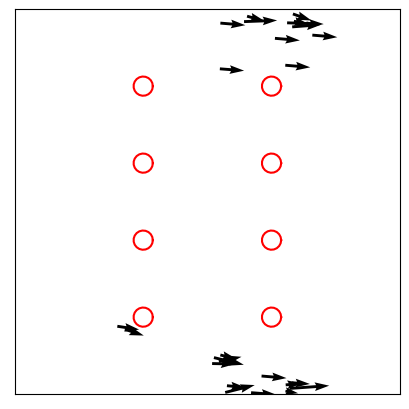

In [ ]:
# =============================================================================
# Importing Packages
# =============================================================================  

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# =============================================================================
# Parameters
# =============================================================================

# -----------------------------------------------------------------------------
# Birds
# -----------------------------------------------------------------------------

N = 25                   # Number of birds

bird_speed = 1.0         # Ideal constant speed of birds 
bird_speed_max = 1.0     # Maximum speed of birds 

R_bird = .8            # Bird-Bird neighbour view radius
R_min =  .3             # Bird-Bird minimum distance to maintain


R_obs = 3.0              # Bird-object view radius

# Migration vector goal
goal_angle = np.random.uniform(0, 2 * np.pi)  # Random angle in [0, 2π)
goal_x = np.cos(goal_angle) 
goal_y = np.sin(goal_angle)

# -----------------------------------------------------------------------------
# 'Mixing' parameters
# -----------------------------------------------------------------------------

# These are weights for the different contributions to the bird's velocity

lam_c = .3               # Centering weight
lam_a = .7              # Avoidance weight
lam_m = .4               # Matching weight
lam_g = .2              # Migratory weight

# The obstacle velocity weight is calculated dynamically

# -----------------------------------------------------------------------------
# Time & Space
# -----------------------------------------------------------------------------

L = 10                   # Size of box (Area of a wind farm)

dt = 0.1                 # Time step
Nt = 200                 # No. of time steps


# =============================================================================
# Obstacle Functions
# =============================================================================

def make_circular_obstacle(x_centre, y_centre, R, n=20):
    '''
    Returns x,y points defining a circular obstacle
    '''
    angles = np.linspace(0, 2 * np.pi, n)
    
    x = x_centre + R*np.cos(angles)
    y = y_centre + R*np.sin(angles)
    
    return x, y


def make_rectangular_obstacle(x_centre, y_centre, L1, L2, n=25):
    '''
    Returns x,y points defining a rectangular obstacle
    '''
    
    # Number of points per side
    points_per_side = n // 4
    
    # Half lengths for width and height
    l1 = L1 / 2
    l2 = L2 / 2
    
    # Corners of the rectangle
    top_left = [x_centre - l1, y_centre + l2]
    top_right = [x_centre + l1, y_centre + l2]
    bottom_left = [x_centre - l1, y_centre - l2]
    bottom_right = [x_centre + l1, y_centre - l2]
    
    # Initialize lists for x and y points
    x_points = []
    y_points = []
    
    # Generate points along each side
    # Top edge (left to right)
    x_points.extend(np.linspace(top_left[0], top_right[0], points_per_side))
    y_points.extend([top_left[1]] * points_per_side)
    
    # Right edge (top to bottom)
    x_points.extend([top_right[0]] * points_per_side)
    y_points.extend(np.linspace(top_right[1], bottom_right[1], points_per_side))
    
    # Bottom edge (right to left)
    x_points.extend(np.linspace(bottom_right[0], bottom_left[0], points_per_side))
    y_points.extend([bottom_left[1]] * points_per_side)
    
    # Left edge (bottom to top)
    x_points.extend([bottom_left[0]] * points_per_side)
    y_points.extend(np.linspace(bottom_left[1], top_left[1], points_per_side))
    
    return x_points, y_points

def get_obstacle_centre_grid(L, num_obstacles, nrows, ncols):
    '''
    Define the centre of obstacles based on a grid.
    '''
    x_spacing = L / (ncols + 1)
    y_spacing = L / (nrows + 1)
    
    x_centres = []
    y_centres = []

    # Calc grid positions
    cnt = 0
    for i in range(nrows):
        for j in range(ncols):
            if cnt > num_obstacles:
                break
        
            # Calculate centre positions
            x_centre = (j + 1) * x_spacing
            y_centre = (i + 1) * y_spacing
            x_centres.append(x_centre)
            y_centres.append(y_centre)
            cnt += 1
    
    return x_centres, y_centres

def get_obstacles(L, num_obstacles, nrows, ncols):
    '''
    Call the obstacle functions and get lists of their x, y points
    '''
    
    x_centres, y_centres = get_obstacle_centre_grid(L, num_obstacles, nrows=nrows, ncols=ncols)
    
    # Initalise lists
    x_obstacle_list = []
    y_obstacle_list = []
    
    for i in range(num_obstacles):
        # Make circular obstacles
        x_obs, y_obs = make_circular_obstacle(x_centres[i], y_centres[i], R=0.25, n=20)
        
        # Make rectangular obstacles
        # x_obs, y_obs = make_rectangular_obstacle(x_centres[i], y_centres[i], L1=1, L2=0.2, n=25)
        
        x_obstacle_list.append(x_obs)
        y_obstacle_list.append(y_obs)
    
    # Concatenate lists for analysis
    x_obstacle = np.concatenate(x_obstacle_list)
    y_obstacle = np.concatenate(y_obstacle_list)
    
    return x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle

# =============================================================================
# Helper Functions
# =============================================================================

def normalise(v):
    """ 
    Normalise a vector to length 1 
    
    Inputs:
        v (numpy array): A vector.

    Outputs:
        norm_v: The normalised vector.
    
    """
    norm = np.linalg.norm(v)
    
    if norm == 0:
        return v
    
    norm_v = v / norm
    
    return norm_v

def distance(u, v):
    """
    Calculate the Euclidean distance between two vectors.

    Inputs:
        u (numpy array): First vector.
        v (numpy array): Second vector.

    Outputs:
        distance: The Euclidean distance between the two vectors.
    """
    
    distance = np.linalg.norm(u - v)
    
    return distance

# =============================================================================
# Bird Functions
# =============================================================================

# -----------------------------------------------------------------------------
# Initialise Birds
# -----------------------------------------------------------------------------

def flock_random(N, L, bird_speed):
    '''
    Set initial positions, direction, and velocities 
    '''
    # Bird positions are randomly distributed within the square area of side L
    x = np.random.rand(N, 1)*L
    y = np.random.rand(N, 1)*L

    # Bird directions are uniformly distributed across a full 360 degree range
    theta = 2 * np.pi * np.random.rand(N, 1)
    
    # Bird start with the same speed but acorss uniform range of directions 
    vx = bird_speed * np.cos(theta)
    vy = bird_speed * np.sin(theta)

    return x, y, vx, vy

def flock_uniform(N, L, bird_speed):
    '''
    Set initial positions as a uniform placement starting at the edge of the box.
    Set direction and velocity to be uniform with a small amount of noise 
    '''

    # Set bird initial flock as a square
    N_per_side = int(np.sqrt(N))
    
    # Midpoint of area 
    midpoint = L//2
    
    # Define the x locations (start in centre of perimeter)
    half_length = N_per_side // 2
    start = midpoint - half_length
    x_locs = np.arange(start, start + N_per_side)
    
    # Define the y locations (start from bottom)
    y_locs = np.arange(0, N_per_side)
    
    # Define bird starting points
    # Initialise lists
    x = []
    y = []
    
    for x_loc in x_locs:
        for y_loc in y_locs:
            x.append([x_loc])
            y.append([y_loc])
    
    # Turn into numpy arrays
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    # Bird Angle
    # Make all birds same starting angle
    theta = 2 * np.pi * np.random.rand(N, 1)

    # Bird velocities
    vx = bird_speed * np.cos(theta)
    vy = bird_speed * np.sin(theta)
  
    return x, y, vx, vy

# -----------------------------------------------------------------------------
# Find Neighbours
# -----------------------------------------------------------------------------

def proximity_lists(i, x, y, R_bird, R_min):
    """
    The function finds the neighbouring and too close birds for a specific bird
    """

    # Compute distances from bird "i" to all other birds
    distances = np.sqrt((x - x[i])**2 + (y - y[i])**2)
    
    # Define the set of neighbours that the bird can see
    neighbours = np.where(distances <= R_bird)[0]
        
    # Define the set of birds that are too close
    too_close = np.where(distances <= R_min)[0]

    # Excluding the bird itself
    neighbours = neighbours[neighbours != i]
    too_close = too_close[too_close != i]   
    
    return neighbours, too_close    

# -----------------------------------------------------------------------------
# Centre Velocity - Move towards the centre of the flock
# -----------------------------------------------------------------------------
  
def centre_vel(i, x, y, neighbours):
    
    # If there are no neighbors, no center-of-mass contribution
    if len(neighbours) == 0:
        return 0, 0

    # Compute center of mass of neighbors
    com_x = np.mean(x[neighbours])
    com_y = np.mean(y[neighbours])

    # Compute the vector pointing towards the center of mass
    direction_to_com = np.array([com_x - x[i][0], com_y - y[i][0]])

    # Normalize the vector
    normalized_direction = normalise(direction_to_com)

    # Extract the components
    centre_vx, centre_vy = normalized_direction

    return centre_vx, centre_vy
    
# -----------------------------------------------------------------------------
# Avoidance Velocity - avoid colissions with to align with other birds
# -----------------------------------------------------------------------------
    
def avoid_vel(i, x, y, too_close):
     # If there are no birds too close, no avoidance needed
     if len(too_close) == 0:
         return 0, 0

     # Initialize avoidance velocity components
     avoid_vx = 0
     avoid_vy = 0

     # Compute avoidance velocity contributions for all too close birds
     for idx in too_close:
         avoid_vx += (x[i][0] - x[idx][0])
         avoid_vy += (y[i][0] - y[idx][0])
     
     # Normalize the avoidance vector to ensure a unit direction
     normalised_avoidance = normalise(np.array([avoid_vx, avoid_vy]))

     # Extract the components
     avoid_vx, avoid_vy = normalised_avoidance

     return avoid_vx, avoid_vy

# -----------------------------------------------------------------------------
# Matching Velocity - match velocity to align with neighbours
# -----------------------------------------------------------------------------
    
def match_vel(i, vx, vy, neighbours):
    
    # Check if there are no neighbors
    if len(neighbours) == 0:
        return 0, 0

    # Calculate average neighbor velocity
    avg_vx = np.mean(vx[neighbours])
    avg_vy = np.mean(vy[neighbours])

    # Compute the velocity difference vector
    velocity_difference = np.array([avg_vx - vx[i][0], avg_vy - vy[i][0]])

    # Normalize the velocity difference to ensure a unit vector
    normalized_match = normalise(velocity_difference)

    # Extract the components
    match_vx, match_vy = normalized_match

    return match_vx, match_vy

# -----------------------------------------------------------------------------
# Migration Velocity - a common goal velocity for the flock
# -----------------------------------------------------------------------------

def migratory_vel(goal_x, goal_y):
    
    normalized_goal = normalise(np.array([goal_x, goal_y]))
    
    migrate_vx, migrate_vy = normalized_goal
    
    return migrate_vx, migrate_vy


# =============================================================================
# Obstacle Velocity - velocity to steer away from incoming obstacles
# =============================================================================
def obstacle_vel(i, x, y, vx, vy, R_min, R_obs, x_obstacle_list, y_obstacle_list, num_samples=10):
    # Initialize obstacle velocity as 0
    obstacle_vx = 0
    obstacle_vy = 0
    lam_o = 0

    # Get current location of the bird
    bird_loc = np.array([x[i][0], y[i][0]])

    # Create uniformly spaced points along the bird's "line of travel"
    # This is maxed at the bird obstacle viewing radius
    travel_vec = normalise(np.array([vx[i][0], vy[i][0]]))
    lot_values = np.linspace(0, R_obs, num_samples).reshape(-1, 1)
    lot_points = bird_loc + lot_values * travel_vec

    # Loop over each obstacle and find the closest point
    min_distance = np.inf
    closest_point = None

    for x_obs, y_obs in zip(x_obstacle_list, y_obstacle_list):
        for obs_x, obs_y in zip(x_obs, y_obs):
            for lot_x, lot_y in lot_points:
                distance_to_bird = np.linalg.norm(np.array([obs_x, obs_y]) - np.array([lot_x, lot_y]))
                if distance_to_bird < min_distance:
                    min_distance = distance_to_bird
                    closest_point = np.array([obs_x, obs_y])

    # If the closest point is within the bird's minimum safe distance, calculate the avoidance velocity
    if min_distance <= R_min:
        direction_away = bird_loc - closest_point
        normalised_direction = normalise(direction_away)
        obstacle_vx, obstacle_vy = normalised_direction

        # Calculate obstacle velocity weight
        p = 3  # Control steepness (tune this value)
        normalized_distance = min(min_distance / R_min, 1)
        lam_o = (1 - normalized_distance) ** p

    return obstacle_vx, obstacle_vy, lam_o


# -----------------------------------------------------------------------------
# Update velocities
# -----------------------------------------------------------------------------
       
def update_velocity(i, vx, vy, \
                    obstacle_vx, obstacle_vy, \
                    centre_vx, centre_vy, \
                    avoid_vx, avoid_vy, \
                    match_vx, match_vy, \
                    migrate_vx, migrate_vy, \
                    bird_speed, \
                    bird_speed_max, \
                    lam_a, \
                    lam_c, \
                    lam_m, \
                    lam_o, \
                    lam_g):
    
    # if lam_o > 0.9:
        
    #     vx_new = bird_speed * obstacle_vx
                 
    #     vy_new = bird_speed * obstacle_vy
        
    
    # Update velocities with contributions
    vx_new = vx[i][0] + \
             lam_o * obstacle_vx + \
             lam_c * centre_vx + \
             lam_a * avoid_vx + \
             lam_m * match_vx + \
             lam_g * migrate_vx
             
    vy_new = vy[i][0] + \
             lam_o * obstacle_vy + \
             lam_c * centre_vy + \
             lam_a * avoid_vy + \
             lam_m * match_vy + \
             lam_g * migrate_vy

    
    # Compute the current speed
    current_speed = np.linalg.norm([vx[i][0], vy[i][0]])
    
    # Add small noise to the direction
    # noise_factor = 0.01 * current_speed  
    # vx_new += np.random.uniform(-noise_factor, noise_factor)
    # vy_new += np.random.uniform(-noise_factor, noise_factor)
    

#CHANGED HERE 2222222222222222222222222222222222222222
    speed_factor = min(1, bird_speed_max / current_speed)
    vx_new = speed_factor * vx_new
    vy_new = speed_factor * vy_new

        
    return vx_new, vy_new

# =============================================================================
# Update Steps
# ============================================================================= 

def step(x, y, vx, vy, L, R_bird, R_min, N, dt, bird_speed_max, lam_a, lam_c, lam_m, lam_g, goal_x, goal_y, x_obstacle_list, y_obstacle_list):
    '''
    
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    
    '''
    
    # Update positions based on velocity and time step
    x += vx * dt
    y += vy * dt
    
    # Apply periodic boundary conditions
    x %= L
    y %= L
    
    # Initialise the new velocities
    vx_new = np.zeros(N)
    vy_new = np.zeros(N)
    
    # For each bird:
    for i in range(N):
        
        # Find neighbouring birds and those that are too close
        neighbours, too_close = proximity_lists(i, x, y, R_bird, R_min)
        
        # Obstacle avoidance component
        obstacle_vx, obstacle_vy, lam_o = obstacle_vel(i, x, y, vx, vy, R_min, R_obs, x_obstacle_list, y_obstacle_list, num_samples = 10)
        
        # Center of mass component
        centre_vx, centre_vy = centre_vel(i, x, y, neighbours)
        
        # Bird avoidance component
        avoid_vx, avoid_vy = avoid_vel(i, x, y, too_close)
        
        # Matching component
        match_vx, match_vy = match_vel(i, vx, vy, neighbours)
        
        # Migrating component
        migrate_vx, migrate_vy = migratory_vel(goal_x, goal_y)
           
        # Update velocity with limits
        vx_new[i], vy_new[i] = update_velocity(i, vx, vy, \
                                obstacle_vx, obstacle_vy, \
                                centre_vx, centre_vy, \
                                avoid_vx, avoid_vy, \
                                match_vx, match_vy, \
                                migrate_vx, migrate_vy, \
                                bird_speed, \
                                bird_speed_max, \
                                lam_a, \
                                lam_c, \
                                lam_m, \
                                lam_o, \
                                lam_g)
    

    # Update new velocities
    vx = np.array(vx_new).reshape(-1, 1)
    vy = np.array(vy_new).reshape(-1, 1)
    
    return x, y, vx, vy



def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    

    q.set_UVC(vx,vy)
    
    return q


# Get obstacles
# Number of obstacles
num_obstacles = 8
nrows = 4
ncols = 2

x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle = get_obstacles(L, num_obstacles, nrows, ncols)

# Initialize figure and axes
fig, ax = plt.subplots(figsize=(5, 5))

# Plot obstacles
for xx, yy in zip(x_obstacle_list, y_obstacle_list):
    ax.plot(xx, yy, 'r-')

# Get the initial bird configuration
x, y, vx, vy = flock_uniform(N, L, bird_speed)

# Initialize quiver plot for birds
q = ax.quiver(x, y, vx, vy)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Define the update function for the animation
def update_func(frame):
    """
    Update function for each frame in the animation.
    """
    global x, y, vx, vy
    
    # Update bird positions and velocities
    x, y, vx, vy = step(x, y, vx, vy, L, R_bird, R_min, N, dt, 
                        bird_speed_max, lam_a, lam_c, lam_m, lam_g, 
                        goal_x, goal_y, x_obstacle_list, y_obstacle_list)
    
    # Update the quiver plot with new data
    q.set_offsets(np.column_stack([x, y]))
    q.set_UVC(vx, vy)
    
    
    return q,

# Create the animation
ani = FuncAnimation(fig, update_func, frames=Nt, interval=50, blit=True)

# Display the animation in the notebook
display(HTML(ani.to_jshtml()))

# Show the animation
plt.show()
